In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import signal, stats
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
import torch
import torch.nn as nn
from math import floor

path_2 = './part_2'

## Initial Data Load

In [ ]:
assets = pd.read_csv(path_2 + '/assets.csv')
collects = pd.read_csv(path_2 + '/collects.csv')

In [ ]:
assets['sensors'] = assets['sensors'].str[2:-2]
assets = assets.rename(columns={'sensors':'sensorId'})
assets['createdAt'] = pd.to_datetime(assets['createdAt']).dt.tz_localize(None)
assets.head()

In [ ]:
assets.info()

In [ ]:
collects = collects.rename(columns={'createdAt':'created'})
collects = collects.drop_duplicates('_id')
collects['created'] = pd.to_datetime(collects['created']).dt.tz_localize(None)
collects.head()

In [ ]:
collects.info()

In [ ]:
print(assets['sensorId'].unique())
print(collects['sensorId'].unique())

In [ ]:
# relacionamento entre base de ativos e monitoramento
full_df = collects.merge(assets, how='left', on='sensorId')
full_df.head()

## Creating assets data object

In [ ]:
class Asset:
    def __init__(self, df, row):
        self.sensorID = row['sensorId']
        self.company = row['company']
        self.description = row['description']
        self.model = row['model']
        self.modelType = row['modelType']
        self.name = row['name']
        self.axisX = row['specifications.axisX']
        self.axisY = row['specifications.axisY']
        self.axisZ = row['specifications.axisZ']
        self.maxDowntime = row['specifications.maxDowntime']
        self.maxTemp = row['specifications.maxTemp']
        self.power = row['specifications.power']
        self.rpm = row['specifications.rpm']
        self.power = row['specifications.power']
        self.workdays = row['specifications.workdays']
        
        self.df = self.setData(df)

        self.calcDownTime()

    def setData(self, df):
        df = df[df['sensorId'] == self.sensorID].sort_values(by='created')
        df['delta_created'] = df['created'].diff(-1)
        df['delta_created'] = df['delta_created'].dt.total_seconds()*-1
        df['time_s'] = df['created']-df['created'].min()
        df['time_s'] = df['time_s'].dt.total_seconds()
        df['time_s_2'] = df['params.timeStart'] - df['params.timeStart'].min()
        df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z']] = df[[
            'params.accelRMS.x',
            'params.accelRMS.y',
            'params.accelRMS.z',
            'params.velRMS.x',
            'params.velRMS.y',
            'params.velRMS.z'
            ]].fillna(np.nan)
        df['time_s_3'] = df['time_s_2']
        df['time_s_2'] = df['time_s_2'].fillna(df['time_s'])
        df = df.reset_index(drop=True)

        self.details = '\
        company: {}\n\
        name: {}\n\
        sensorID: {}\n\
        model: {}\n\
        model type: {}\n\
        maxTemp: {}\n\
        power: {}\n\
        rpm: {}'.format(
            self.company,
            self.name,
            self.sensorID,
            self.model,
            self.modelType,
            self.maxTemp,
            self.power,
            self.rpm)
        
        return df
    
    def plotData(self):
        # diagram plots
        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        l1, = axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        l2 = axes[1][0].axhline(y = self.amp_x*0.05 + self.df['params.accelRMS.x'].min(), color = 'r', linestyle = '-')
        axes[1][0].legend([l1, l2], ['acel. signal', 'upper bound downtime'], loc = 'upper right')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[2][0].axhline(y = self.amp_y*0.05 + self.df['params.accelRMS.y'].min(), color = 'r', linestyle = '-')
        axes[3][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[3][0].axhline(y = self.amp_z*0.05 + self.df['params.accelRMS.z'].min(), color = 'r', linestyle = '-')

        axes[1][1].plot(self.df['time_s_2'], self.df['params.velRMS.x'], color='green')
        axes[2][1].plot(self.df['time_s_2'], self.df['params.velRMS.y'], color='green')
        axes[3][1].plot(self.df['time_s_2'], self.df['params.velRMS.z'], color='green')

        axes[0][1].plot(self.df['time_s_2'], self.df['temp'], color = 'orange')

        axes[0][0].text(0.05, 0.95, self.details, fontsize=8, horizontalalignment='left', verticalalignment='top')

        fig.suptitle('Asset - {}'.format(self.name))
        axes[0,0].set_title('details')
        axes[0,1].set_title('temp.')
        axes[1,0].set_title('acel.')
        axes[1,1].set_title('veloc.')
        axes[1,0].set_ylabel('x')
        axes[2,0].set_ylabel('y')
        axes[3,0].set_ylabel('z')
        axes[3,0].set_xlabel('time')
        axes[3,1].set_xlabel('time')

    def calcDownTime(self):
        # calculo e impressão de downtime
        self.amp_x = self.df['params.accelRMS.x'].max() - self.df['params.accelRMS.x'].min()
        self.amp_y = self.df['params.accelRMS.y'].max() - self.df['params.accelRMS.y'].min()
        self.amp_z = self.df['params.accelRMS.z'].max() - self.df['params.accelRMS.z'].min()

        self.df['downtime'] = np.where(
            ((self.df['params.accelRMS.x'].isnull())|
            (self.df['params.accelRMS.y'].isnull())|
            (self.df['params.accelRMS.z'].isnull()))|
            ((self.df['params.accelRMS.x'] < self.amp_x*0.05 + self.df['params.accelRMS.x'].min())|
            (self.df['params.accelRMS.y'] < self.amp_y*0.05 + self.df['params.accelRMS.y'].min())|
            (self.df['params.accelRMS.z'] < self.amp_z*0.05 + self.df['params.accelRMS.z'].min()))|
            (self.df['delta_created'] > self.df['delta_created'].mean()*1.1), True, False)

        down_df = self.df.iloc[:-1] # excluir primeira linha, pois não tem delta
        down_df = down_df[down_df['downtime']]
        self.totalTime = self.df['params.timeStart'].max() - self.df['params.timeStart'].min()
        self.downTime = down_df['delta_created'].sum()
        print('{} - uptime: {:.0f} s, downtime: {:.0f} s - {:.2f}%'.format(
            self.name, self.totalTime-self.downTime, self.downTime, 100*self.downTime/self.totalTime)
        )

    def normalize(self):
        # normalização dos vetores de aceleração [0,1] preservando a proporção
        max_val = max(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].max())
        min_val = min(self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']].min())
        self.df[
            ['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']
        ] = (self.df[['params.accelRMS.x','params.accelRMS.y','params.accelRMS.z']]-min_val)/(max_val-min_val)
        
        self.df['params.accelRMS.x_n'] = self.df['params.accelRMS.x_n'].fillna(-1)
        self.df['params.accelRMS.y_n'] = self.df['params.accelRMS.y_n'].fillna(-1)
        self.df['params.accelRMS.z_n'] = self.df['params.accelRMS.z_n'].fillna(-1)

    def varDetection(self):
        # teste utilizando Isolation forest
        self.isForest = IsolationForest(contamination=0.04, max_samples=floor(len(self.df)*0.1))
        pred = self.isForest.fit_predict(self.df[['params.accelRMS.x_n','params.accelRMS.y_n','params.accelRMS.z_n']])
        self.df['pred'] = np.where(pred == -1, True, False)
        self.df['params.accelRMS.x_p'] = np.where(self.df['pred'], self.df['params.accelRMS.x'], np.nan)
        self.df['params.accelRMS.y_p'] = np.where(self.df['pred'], self.df['params.accelRMS.y'], np.nan)
        self.df['params.accelRMS.z_p'] = np.where(self.df['pred'], self.df['params.accelRMS.z'], np.nan)

        fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharey=False)
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x'], color='blue')
        axes[0][0].plot(self.df['time_s_2'], self.df['params.accelRMS.x_p'], '-*', color='red')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y'], color='blue')
        axes[1][0].plot(self.df['time_s_2'], self.df['params.accelRMS.y_p'], '-*', color='red')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z'], color='blue')
        axes[2][0].plot(self.df['time_s_2'], self.df['params.accelRMS.z_p'], '-*', color='red')
        pass


In [ ]:
mach = list(assets['sensorId'].unique())
data = {}

# Create asset object and print details
for idx, row in assets.iterrows():
    data[row['sensorId']] = Asset(full_df, row)
    data[row['sensorId']].plotData()
    

## Data normalization for vibration chage detection

In [ ]:
for i in data:
    data[i].normalize()
    # data[row['sensorId']].varDetection()

## Neural network for pattern change detection

In [51]:
class Cnn:
    def __init__(self, data):
        # define datasets
        cols = ['params.accelRMS.x_n','params.accelRMS.y_n', 'params.accelRMS.z_n']
        self.name = data.name
        self.df = data.df[cols + ['time_s_2']]
        self.df = self.df.reset_index(drop=True)

        self.windowLen = floor(len(self.df)/20)
        self.step = floor(len(self.df)/25)

        self.xdataSet = [np.array(self.df[cols].iloc[i:i+self.windowLen].values) for i in range(len(self.df) - (self.windowLen))]
        self.ydataSet = [np.array(self.df[cols].iloc[i+self.windowLen].values) for i in range(len(self.df) - (self.windowLen))]

        self.xdataSet = torch.tensor(np.array(self.xdataSet),dtype=torch.float32, requires_grad=True)
        self.ydataSet = torch.tensor(np.array(self.ydataSet),dtype=torch.float32, requires_grad=True)

        self.xdataSet_train = self.xdataSet[
            [i for i in range(0,len(self.xdataSet),self.step) if not ((-1 in self.xdataSet[i]) | (-1 in self.ydataSet[i]))]]
        self.ydataSet_train = self.ydataSet[
            [i for i in range(0,len(self.ydataSet),self.step) if not ((-1 in self.xdataSet[i]) | (-1 in self.ydataSet[i]))]]
        
        self.cnnModel()
        
    def cnnModel(self):
        self.model = nn.Sequential(
            nn.Conv1d(self.windowLen, floor(self.windowLen/2), 3),
            nn.ReLU(),
            nn.Conv1d(floor(self.windowLen/2), floor(self.windowLen/10), 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(floor(self.windowLen/10), floor(self.windowLen/10)),
            nn.Linear(floor(self.windowLen/10), 3)
        )
        # self.loss_fn = nn.CrossEntropyLoss()
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train(self, epochs):
        for n in range(epochs):
            y_pred = self.model(self.xdataSet_train)
            loss = self.loss_fn(y_pred, self.ydataSet_train)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if n%250 == 0:
                print('{} - loss: {}'.format(n, loss))

    def predict(self):
        loss = []
        pred = []
        for m in range(self.xdataSet.shape[0]):
            y_pred = self.model(self.xdataSet[m].unsqueeze(0))
            loss = loss + [self.loss_fn(y_pred[0], self.ydataSet[m]).item()]
            pred = pred + [list(self.ydataSet[m].detach().numpy())]

        loss = [0]*(len(self.df)-len(loss)) + loss
        pred = [[0,0,0]]*(len(self.df)-len(pred)) + pred

        lossIqr = stats.iqr(loss, rng=(0,90))
        lossMedian = np.median(loss)
        self.lossBound = lossIqr*1.5 + lossMedian
        # self.lossBound = np.percentile(loss, 95)

        self.df['loss'] = loss
        self.df[['pred_x','pred_y','pred_z']] = pred
        self.df['variation_x'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.x_n'], np.nan)
        self.df['variation_y'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.y_n'], np.nan)
        self.df['variation_z'] = np.where(self.df['loss']>self.lossBound, self.df['params.accelRMS.z_n'], np.nan)

    def plotResults(self, data):
        df = data.df.merge(self.df, how='left', on='time_s_2')
        gs = gridspec.GridSpec(3, 3)
        fig = plt.figure(figsize=(25, 10))
        fig.suptitle('Asset - {} normalized vibration'.format(self.name))
        axes = fig.add_subplot(gs[0, 1])
        l1, = axes.plot(df['time_s_2'],df['params.accelRMS.x_n_x'], color='blue')
        l2, = axes.plot(df['time_s_2'],df['pred_x'], color='yellow')
        l3, = axes.plot(df['time_s_2'],df['variation_x'], '-*', color='red')
        axes.legend([l1, l2, l3], ['acel.','prediction', 'variation'], loc = 'upper right')
        axes.set_title('acel.')
        axes = fig.add_subplot(gs[1, 1])
        axes.plot(df['time_s_2'],df['params.accelRMS.y_n_x'], color='blue')
        axes.plot(df['time_s_2'],df['pred_y'], color='yellow')
        axes.plot(df['time_s_2'],df['variation_y'], '-*', color='red')
        axes = fig.add_subplot(gs[2, 1])
        axes.plot(df['time_s_2'],df['params.accelRMS.z_n_x'], color='blue')
        axes.plot(df['time_s_2'],df['pred_z'], color='yellow')
        axes.plot(df['time_s_2'],df['variation_z'], '-*', color='red')
        axes = fig.add_subplot(gs[0, 0])
        axes.text(0.05, 0.95, data.details, fontsize=8, horizontalalignment='left', verticalalignment='top')
        axes.set_title('details')
        axes = fig.add_subplot(gs[1:, 0])
        l1, = axes.plot(df['time_s_2'],df['loss'], color='green')
        l2 = axes.axhline(y = self.lossBound, color = 'r', linestyle = '-')
        axes.legend([l1, l2], ['loss','upper bound'], loc = 'upper right')
        axes.set_title('loss (RMSE)')
        


0 - loss: 0.0430278517305851
250 - loss: 9.234352910425514e-05
500 - loss: 1.2120036444684956e-05
750 - loss: 2.9417475388981984e-07


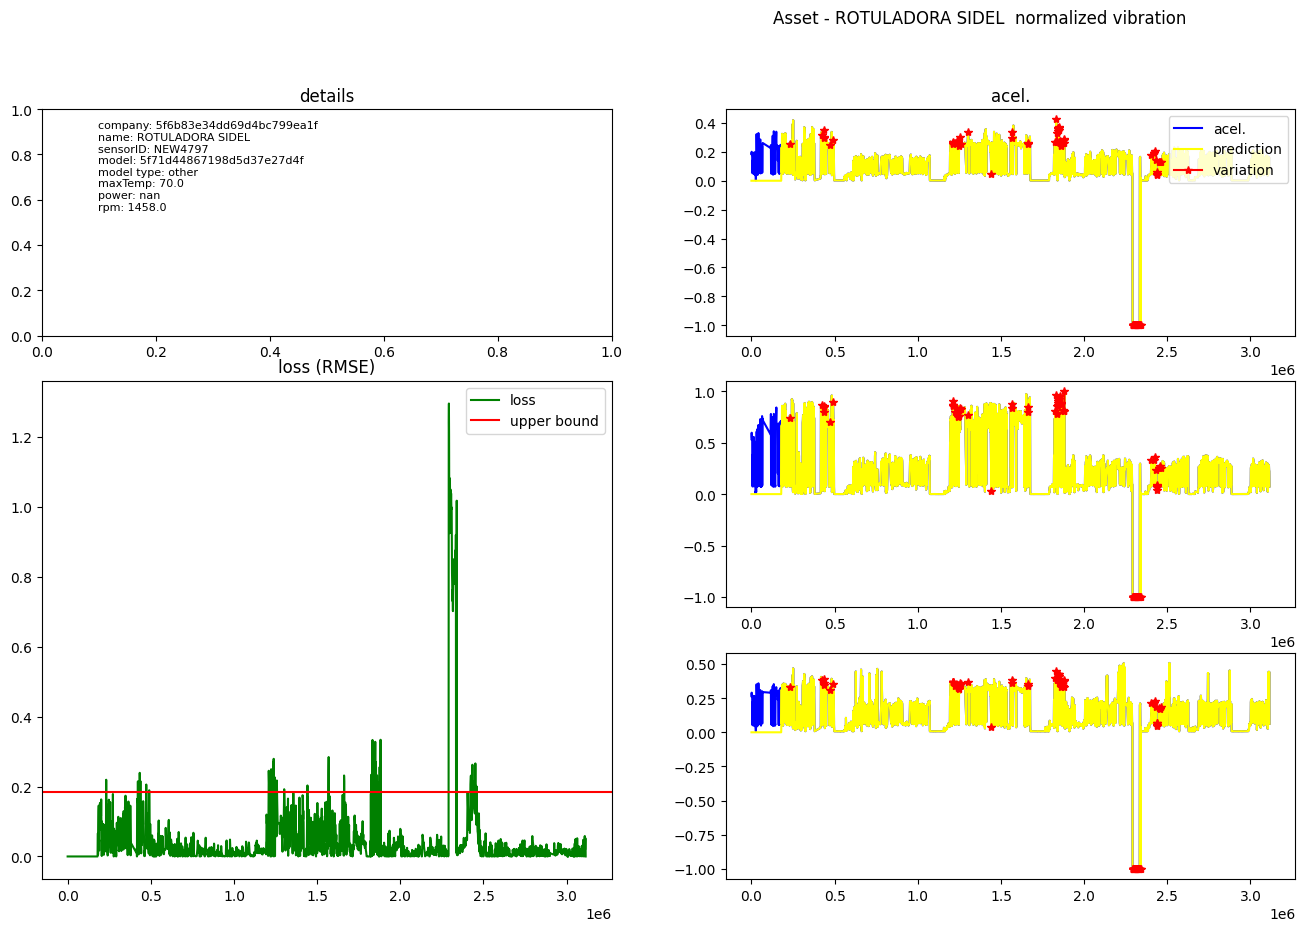

In [52]:
assetCnn = {}
# for i in data:
assetCnn[i] = Cnn(data[i])
assetCnn[i].train(1000)
assetCnn[i].predict()
assetCnn[i].plotResults(data[i])

In [ ]:
# quantile([0.25,0.5,0.75])

data['IAJ9206'].df['time_s_2'].quantile([0.95])

In [ ]:
data['IAJ9206'].df